In [1]:
# for folders one level below the heirarchy
import sys
import os 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

from aodfunctions.dependencies import *
from aodfunctions.general import *
from aodfunctions.settings import *
from aodfunctions.testbed import *
# from aodfunctions.outofplane import *

cupyon=True

try: 
    import cupy as cp
    import cupyx.scipy.fft as cpfft
    import cupyx.scipy.ndimage
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
    from cupy.lib.stride_tricks import as_strided

except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    cupyon = False
    from numpy.lib.stride_tricks import as_strided
    print("cupy not installed. Using numpy.")


## Global Variables - REMEMBER TO UPDATE SETTINGS WHEN CHANGED
# Hardware-defined Constants. Note that all explicit variable values are in position (m), frequency (1/m), or time (s). Conversions are done explicitly to relevant time/distance scales.
aodaperture = 7.5e-3 # Aperture size of the AOD
soundvelocity = 650   # Sound velocity in the medium
cycletime = aodaperture / soundvelocity  # Time for one cycle of the waveform
focallength = 9.1 * 10**(-3) # mm
# focallength = 200 * 10**(-3) # mm
wavelength = 630 * 10**(-9)

print("Cycletime in nanoseconds: ", cycletime * 1e9)

# Simulation Constants
numpix_frame = 2000
numpix_real = 4096
pixelsize_real = aodaperture / numpix_frame
aperturesize_real = numpix_real * pixelsize_real
aperturesize_fourier = wavelength * focallength / (pixelsize_real)
pixelsize_fourier = aperturesize_fourier / numpix_real
print("Aod pixel pitch in microns: ", pixelsize_real*1e6)
print("Fourier space spacing in microns: ", pixelsize_fourier*10**6)
print("Fourier space aperture in microns: ", aperturesize_fourier*10**6)

# Adjustable Variables
movementtime = 10*10**(-6) # Time for the movement of the AOD
timestep = cycletime / numpix_frame
print("Timestep in nanoseconds:", timestep * 10**9)
startlocation = 0.1*10**(-6) # Start location of the AOD in microns. 0 is set to the center of Fourier space.
endlocation = 300*10**(-6) # End location of the AOD in microns


optimizationbasisfunctions = 'Chebyshev'  # Basis for the polynomial fit
numcoefficients = 100

num_particles = 10000
atommass = 1.41922*10**(-25) # Mass of the atom
tweezerdepth = 10*10**6 # Depth of the tweezer in Hertz
hbar = 6.626*10**(-34)


globalvariables = [aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients]
aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables



### From the global variables, initialize the AWG waveform
numpix_waveform = int(movementtime / cycletime * numpix_frame) + 2* numpix_frame # Why is there a 2* cycletime here? To add on the initial and final stages of the AOD. We will only change the portion in the movement time and fix the ends.
AWGwaveform = cp.zeros(numpix_waveform)

print("Tweezer starting positions:", startlocation*10**6, "microns or", micronstoMHz(startlocation, globalvariables) /10**6, "MHz")
print("Tweezer ending positions:", endlocation*10**6, "microns or", micronstoMHz(endlocation, globalvariables) /10**6, "MHz")
print("One micron corresponds to", micronstoMHz(1e-6, globalvariables) /10**6, "MHz")
print(len(AWGwaveform))

cupy not installed. Using numpy.
Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  14.999999999999998
Fourier space spacing in microns:  0.09331054687500001
Fourier space aperture in microns:  382.20000000000005
Timestep in nanoseconds: 23.076923076923077
cupy not installed. Using numpy.
Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  3.7499999999999996
Fourier space spacing in microns:  0.37324218750000004
Fourier space aperture in microns:  1528.8000000000002
Timestep in nanoseconds: 5.769230769230769
Tweezer starting positions: 0.09999999999999999 microns or 0.011337868480720086 MHz
Tweezer ending positions: 300.0 microns or 34.01360544217687 MHz
One micron corresponds to 0.1133786848072586 MHz
5733


In [2]:
import diffractsim
diffractsim.set_backend("CPU") #Change the string to "CUDA" to use GPU acceleration

from diffractsim import MonochromaticField, Lens, nm, mm, cm, RectangularSlit, GaussianBeam

In [3]:
optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time  = initpath_sinsqramp_general(globalvariables)

fourierpixels, time = positionstofourier(optimized_position, time, globalvariables)

expanded_position, expanded_time = expand_position_array(time, fourierpixels, globalvariables)
expanded_acceleration, expanded_time = expand_position_array(time, optimized_acceleration, globalvariables)

AWGinitguess = initguess_waveform(AWGwaveform, optimized_position, time, globalvariables)
AWGinitguesscosine = cosinephaseresponse(AWGinitguess)
AWGinitguessexponential = exponentialphaseresponse(AWGinitguess)
# init_forces = retrieveforces(AWGinitguessexponential, globalvariables, 10, True)
# init_potentials = retrievepotentials(AWGinitguessexponential, globalvariables, 10, True)

fittedwaveform, fittedlegendre = init_opt_waveformfitLegendre(AWGinitguess, 1000, globalvariables)

c:\cleen\Apps\Python3.11\Lib\site-packages\numpy\polynomial\legendre.py:1412: RankWarning: The fit may be poorly conditioned
  return pu._fit(legvander, x, y, deg, rcond, full, w)


Maximum error: 1.790627948139445e-07


In [4]:
def array_1dto2d(arr, N):
    """
    Stacks a 1D array into a 2D array by repeating it N times along the rows.

    Parameters:
    arr (np.ndarray): The 1D array to be stacked.
    N (int): The number of times to repeat the 1D array along the rows.

    Returns:
    np.ndarray: The resulting 2D array.
    """
    # Ensure the input is a 1D array
    if arr.ndim != 1:
        raise ValueError("Input array must be 1-dimensional")

    # Use np.tile to repeat the array N times along a new axis
    result = cp.tile(arr, (N, 1))
    
    return result

In [13]:
## Option 1: full path propagation
# settings
focallength = 9.2e-3
etalondepth = 3.5e-3
lenstoetalon = 1e-3
reflectivity = 0.5
transmission = 1 - reflectivity
num_reflections = 1


AWGframe_E = tocupy(array_1dto2d(AWGinitguessexponential[-numpix_frame:], numpix_frame))


F = MonochromaticField(
    wavelength = wavelength, extent_x=numpix_frame * pixelsize_real, extent_y=numpix_frame * pixelsize_real, 
    Nx=numpix_frame, Ny=numpix_frame, intensity =1.
)
F.E = AWGframe_E
F.propagate(focallength)
F.add(Lens(focallength, radius = numpix_frame * pixelsize_real / 2))
# for b in range(int(lenstoetalon // (1e-6))):
#     F.propagate(1e-6)
F.propagate(lenstoetalon)

Enet = F.E * 0

for i in range(num_reflections):
    F.propagate(etalondepth)
    Enet += F.E * transmission
    F.E = F.E * reflectivity
    F.propagate(etalondepth)

F.E = Enet
F.scale_propagate(focallength-etalondepth-lenstoetalon, scale_factor = 100)


# F.zoom_propagate(focallength-etalondepth-lenstoetalon,         
#             x_interval = [endlocation-1e-5, endlocation+1e-5], y_interval = [- 1e-5, +1e-5])

I = F.get_intensity()


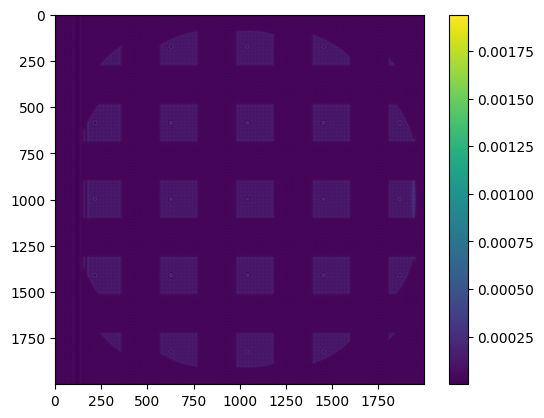

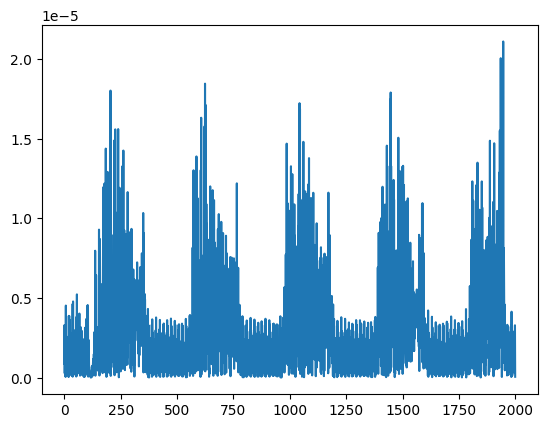

In [14]:
# plt.imshow(sp_gaussian_filter(I.get(),5))
# plt.show()
plt.imshow(I)
plt.colorbar()
plt.show()

Icut = I[(len(I)-1)//2]
plt.plot(Icut)
plt.show()

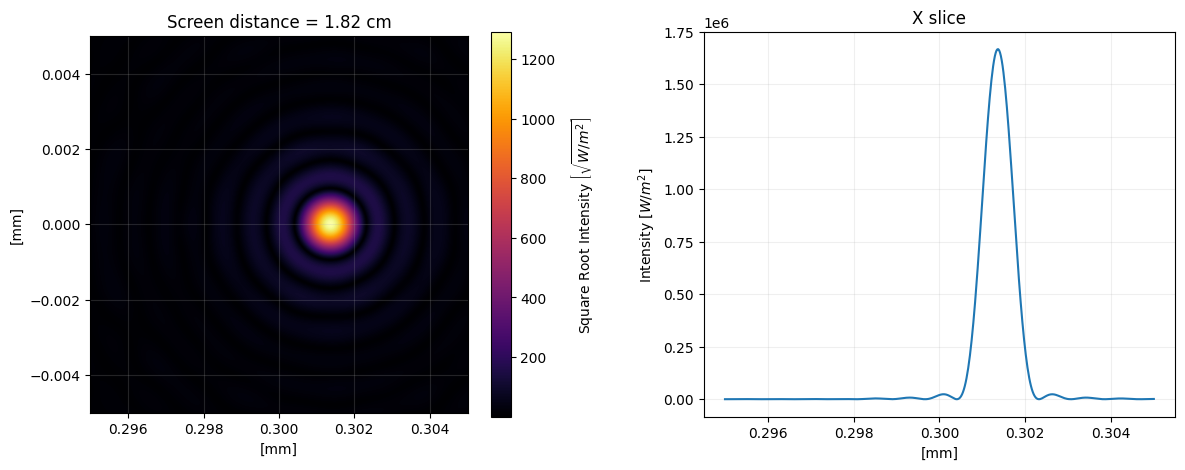

In [99]:
## Option  2: Phase plate
test2d = tonumpy(array_1dto2d(AWGinitguessexponential[-500:], 2))

F = MonochromaticField(
    wavelength = 632.8 * nm, extent_x=20. * mm, extent_y=20. * mm, Nx=500, Ny=2, intensity =2.
)


n1 =1 
n2 = 2.6
h = 0.005 # width of port
R = 0.4 # reflectivity
d = focallength / 4 # distance of port from obj
thetamax = np.arctan((aperturesize_real*numpix_frame/numpix_real)/focallength)
L = 2*(focallength - d)*np.tan(thetamax)

from aodfunctions.diffractsim.diffractsim.light_sources.light_source import LightSource
class ArbitraryBeam(LightSource):
    def __init__(self, Ein):
        """
        Creates a Gaussian beam with waist radius equal to w0
        """
        self.Ein = Ein

    def get_E(self, Ein, xx, yy, λ):
        Eout =  self.Ein
        return Eout

def fp_phase(inputphase):
    empty = np.zeros_like(inputphase)
    xlen = np.shape(inputphase)[0]
    ylen = np.shape(inputphase)[1]
    radius = xlen//2
    for i in range(0,xlen,1):
        for j in range(0,ylen,1):
            offset = d / ((L/2)/radius) *0
            r = np.sqrt((radius+offset-i)**2 + (radius-j)**2)
            Lequiv = L/2 * r/radius
            theta1 = np.arctan(Lequiv / (focallength-d))
            theta2 = np.arcsin(n1 / n2 * np.sin(theta1))
            delta = 2*2*np.pi / wavelength * n2 * h * np.cos(theta2)
            empty[i,j] = delta
    return empty
        
def fp_int(fpphase):
    empty = np.zeros_like(fpphase)
    F= 4*R / (1-R)**2
    empty = 1/(1+F*np.sin(np.abs(fpphase)/2)**2)
    return empty

def Etalon(Etemplate):
    fpphase = fp_phase(Etemplate)
    fpint = fp_int(fpphase)
    fpint = fpint
    
    
    return fpint * np.exp(fpphase*1j)


test2d = tonumpy(array_1dto2d(AWGinitguessexponential[-500:], 500))
F = MonochromaticField(
    wavelength = 632.8 * nm, extent_x=numpix_frame * pixelsize_real, extent_y=numpix_frame * pixelsize_real, Nx=500, Ny=500, intensity=1
)

etalonE = Etalon(F.E)
F.set(ArbitraryBeam(test2d))
# F.E = test2d / np.sum(np.abs(test2d**2))
F.propagate(focallength)
F.set(Lens(f=focallength, radius=numpix_frame * pixelsize_real / 2))
# F.propagate(5e-3)
F.multiply(ArbitraryBeam(etalonE.astype(np.complex128)))

# F.propagate(focallength-d)
# F.zoom_propagate(focallength, x_interval = [startlocation - 1e-5, startlocation+1e-5], y_interval = [- 1e-5, +1e-5])

# # F.zoom_propagate(focallength-d, x_interval = [-numpix_frame * pixelsize_real //2 , numpix_frame * pixelsize_real //2], y_interval = [-numpix_frame * pixelsize_real //2,numpix_frame * pixelsize_real //2])
# # F.zoom_propagate(focallength, x_interval = [- 1e-6, +1e-6], y_interval = [- 1e-6, +1e-6])
# # F.propagate(d)
F.zoom_propagate(focallength, x_interval = [endlocation - 5e-6, endlocation+5e-6], y_interval = [- 5e-6, +5e-6])

# plot the intensity
I = F.get_intensity()
    
F.plot_intensity(I, square_root = True, units = mm, grid = True, figsize = (14,5), slice_y_pos = 0*mm)


F2 = MonochromaticField(
    wavelength = 632.8 * nm, extent_x=numpix_frame * pixelsize_real, extent_y=numpix_frame * pixelsize_real, Nx=500, Ny=500, intensity=1
)

F2.set(ArbitraryBeam(test2d))
# F.E = test2d / np.sum(np.abs(test2d**2))
F2.propagate(focallength)
F2.set(Lens(f=focallength, radius=numpix_frame * pixelsize_real / 2))
# F.propagate(focallength-d)
F2.zoom_propagate(focallength, x_interval = [endlocation - 5e-6, endlocation+5e-6], y_interval = [- 5e-6, +5e-6])

I2 = F2.get_intensity()


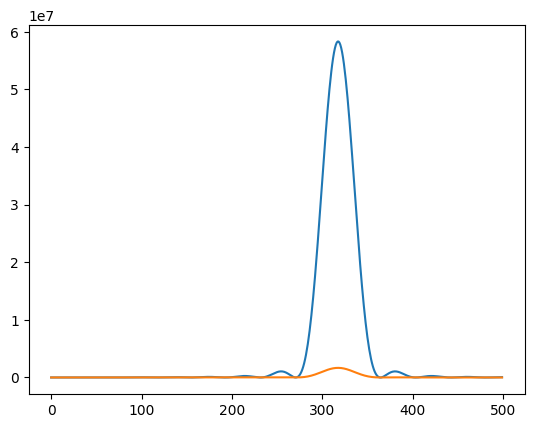

In [101]:
plt.plot(I2[250,:])
plt.plot(I[250,:])

In [27]:
F.E

array([[-0.4917855 +0.86113452j,  0.63373731+0.55441538j,
         0.38361975-0.62155742j, ..., -0.86108965+0.81097498j,
        -0.13068618-1.21083766j,  1.05428104+0.37360245j],
       [ 0.86522529+0.48455219j,  0.54908539-0.63836089j,
        -0.62475021-0.37839782j, ...,  0.81816217+0.8542637j ,
        -1.20970004+0.14082804j,  0.36475478-1.05737469j],
       [ 0.25170727-0.95919189j, -0.75580801-0.37115177j,
        -0.20935413+0.69976324j, ...,  0.62138813-1.00649521j,
         0.44014557+1.13555211j, -1.11509324-0.08748918j],
       ...,
       [-0.96259218+0.23837351j,  0.03611848+0.84124601j,
         0.7145632 -0.15131813j, ..., -1.18115303-0.06350841j,
         0.78609758-0.93019208j,  0.45719566+1.02081312j],
       [ 0.25170727-0.95919189j, -0.75580801-0.37115177j,
        -0.20935413+0.69976324j, ...,  0.62138813-1.00649521j,
         0.44014557+1.13555211j, -1.11509324-0.08748918j],
       [ 0.86522529+0.48455219j,  0.54908539-0.63836089j,
        -0.62475021-0.37839782

In [29]:
F.E

array([[-0.99234407+0.123504j  ,  0.13181521+0.99127431j,
         0.92639174-0.3765612j , ..., -0.77420917-0.63292983j,
         0.92639174-0.3765612j ,  0.13181521+0.99127431j],
       [ 0.13181521+0.99127431j,  0.99013493-0.14011715j,
        -0.38431086-0.92320375j, ..., -0.62641997+0.77948574j,
        -0.38431086-0.92320375j,  0.99013493-0.14011715j],
       [ 0.92639174-0.3765612j , -0.38431086-0.92320375j,
        -0.79708566+0.60386626j, ...,  0.91183266+0.41056205j,
        -0.79708566+0.60386626j, -0.38431086-0.92320375j],
       ...,
       [-0.77420917-0.63292983j, -0.62641997+0.77948574j,
         0.91183266+0.41056205j, ..., -0.07623879-0.99708959j,
         0.91183266+0.41056205j, -0.62641997+0.77948574j],
       [ 0.92639174-0.3765612j , -0.38431086-0.92320375j,
        -0.79708566+0.60386626j, ...,  0.91183266+0.41056205j,
        -0.79708566+0.60386626j, -0.38431086-0.92320375j],
       [ 0.13181521+0.99127431j,  0.99013493-0.14011715j,
        -0.38431086-0.92320375

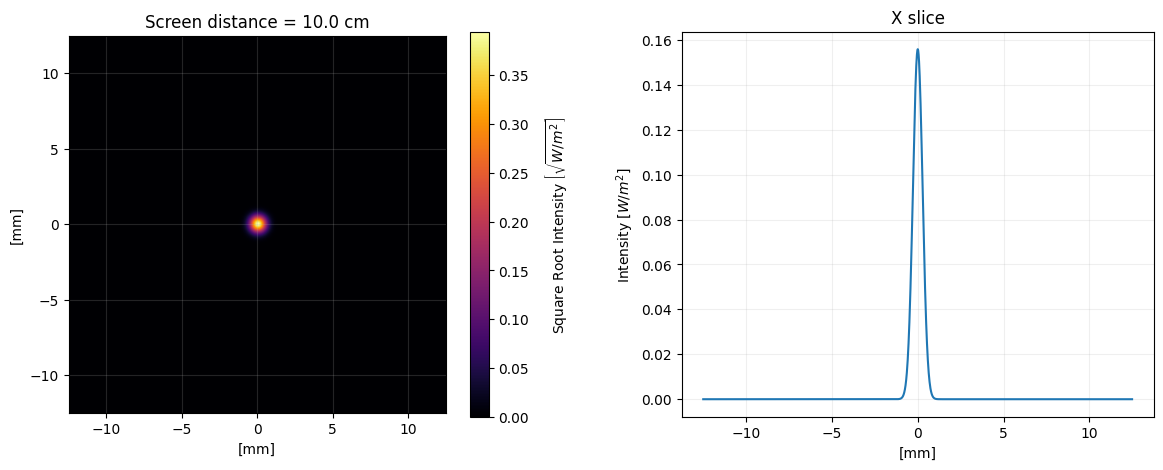

In [216]:
import diffractsim
diffractsim.set_backend("CPU") #Change the string to "CUDA" to use GPU acceleration

from diffractsim import MonochromaticField, GaussianBeam, Lens, CircularAperture, SpatialNoise, nm, mm, cm

F = MonochromaticField(
    wavelength=632.8 * nm, extent_x=25. * mm, extent_y=25. * mm, Nx=2000, Ny=2000,intensity = 0.1
)


F.add(GaussianBeam(w0 = 0.7*mm))

F.add(Lens(f = 50*cm))
F.propagate(10*cm)

I = F.get_intensity()
    
F.plot_intensity(I, square_root = True, units = mm, grid = True, figsize = (14,5), slice_y_pos = 0*mm)

 



In [187]:
np.angle(test2d)

array([[-1.34161131, -1.0127876 , -0.68396388, ..., -1.27904464,
        -0.95022092, -0.62139721],
       [-1.34161131, -1.0127876 , -0.68396388, ..., -1.27904464,
        -0.95022092, -0.62139721],
       [-1.34161131, -1.0127876 , -0.68396388, ..., -1.27904464,
        -0.95022092, -0.62139721],
       ...,
       [-1.34161131, -1.0127876 , -0.68396388, ..., -1.27904464,
        -0.95022092, -0.62139721],
       [-1.34161131, -1.0127876 , -0.68396388, ..., -1.27904464,
        -0.95022092, -0.62139721],
       [-1.34161131, -1.0127876 , -0.68396388, ..., -1.27904464,
        -0.95022092, -0.62139721]])

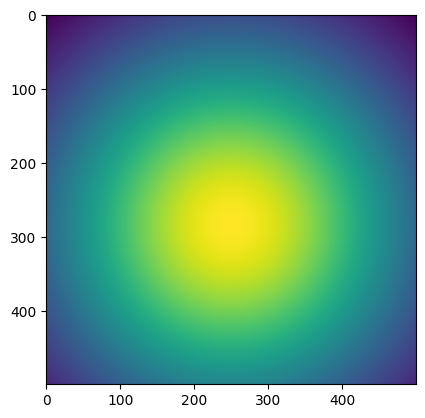

In [198]:
n1 =1 
n2 = 2.6
h = 0.005 # width of port
R = 0.45 # reflectivity
d = focallength / 10 # distance of port from obj
thetamax = np.arctan((aperturesize_real*numpix_frame/numpix_real)/focallength)
L = 2*(focallength - d)*np.tan(thetamax)
plt.imshow(cp.abs(fp_phase(test2d)))